Below, I install my own implementation of Professor Boonstra's "memoize DataFrame to disk" feature. The source code can be found at [github.com/ethho/memoize](https://github.com/ethho/memoize).

In [1]:
!python3 -m pip install git+https://github.com/ethho/memoize.git

  Cloning https://github.com/ethho/memoize.git to /tmp/pip-req-build-6y7v2xz1
  Running command git clone --filter=blob:none --quiet https://github.com/ethho/memoize.git /tmp/pip-req-build-6y7v2xz1
  Resolved https://github.com/ethho/memoize.git to commit bef633bd22e4acde44cccb63399a176c6cef79b9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [136]:
import json
import re
import os
from glob import glob
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import quandl
import functools
import plotly.express as px
import plotly.graph_objects as go
from joblib import Parallel, delayed
import multiprocessing
from memoize.dataframe import memoize_df
from src.ubacktester import px_plot

%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

# 20230126_hw3_ho_ethan_12350006

@mpcs
@finm33550

Ethan Ho 1/20/2023

----


## Configuration & Helper Functions

The following cell contains helper functions and configuration options that I will use in this notebook.

In [137]:
def get_secrets(fp='./secrets.json'):
    """
    Reads secret values such as API keys from a JSON-formatted file at `fp`.
    """
    with open(fp, 'r') as f:
        data = json.load(f)
    return data

def get_quandl_api_key() -> str:
    """
    Returns Quandl API key stored in secrets.json.
    """
    secrets = get_secrets()
    key = secrets.get('NASTAQ_DATA_API_KEY')
    assert key, f"NASTAQ_DATA_API_KEY field in secrets.json is empty or does not exist"
    return key

def strip_str_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a DataFrame, strips values in columns with string or object
    dtype. I noticed that this was an issue when I saw some m_ticker values
    like "AAPL       " with trailing whitespace.
    """
    for col in df.columns:
        if pd.api.types.is_string_dtype(df[col]) or pd.api.types.is_object_dtype(df[col]):
            df[col] = df[col].str.strip()
    return df

@memoize_df(cache_dir='/tmp/memoize')
def fetch_quandl_quotemedia_prices(
    start_date, end_date, ticker
) -> pd.DataFrame:
    df = quandl.get_table(
        'QUOTEMEDIA/PRICES',
        date={'gte': start_date, 'lte': end_date},
        ticker=ticker,
        api_key=get_quandl_api_key(),
        paginate=True,
    )
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    return df

@memoize_df(cache_dir='/tmp/memoize')
def fetch_quandl_tbill_prices(
    start_date, end_date,
) -> pd.DataFrame:
    """Fetch table of treasury bill prices from Quandl."""
    df = quandl.get(
        ['USTREASURY/BILLRATES'],
        returns="pandas",
        start_date=start_date,
        end_date=end_date,
        ticker=ticker,
        api_key=get_quandl_api_key(),
    )
    df = df.reset_index().rename(columns={'Date': 'date'})
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    return df

def unique_index_keys(df, level=0) -> List[str]:
    return df.index.get_level_values(level=level).unique().tolist()

def risk_free_rate(**kw) -> float:
    """Calculates risk-free rate R_f from the 3-month T-bill rate."""
    tbill_prices = fetch_quandl_tbill_prices(**kw)
    tbill_returns = tbill_prices[['date', 'USTREASURY/BILLRATES - 13 Wk Coupon Equiv']]
    return tbill_returns

class PlotlyPlotter:
    """
    Mixin class that provides plotting functionality using Plotly Express.
    Requires any subclass to have a `df` attribute that returns a pandas
    DataFrame, which will be plotted when `self.plot()` is invoked.
    Intended to be inherited by a `FeedBase` subclass.
    """
    PX_RANGESELECTOR = dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )

    PX_TICKFORMATSTOPS = [
        dict(dtickrange=[None, 1000], value="%H:%M:%S.%L ms"),
        dict(dtickrange=[1000, 60000], value="%H:%M:%S s"),
        dict(dtickrange=[60000, 3600000], value="%H:%M m"),
        dict(dtickrange=[3600000, 86400000], value="%H:%M h"),
        dict(dtickrange=[86400000, 604800000], value="%e. %b d"),
        dict(dtickrange=[604800000, "M1"], value="%e. %b w"),
        dict(dtickrange=["M1", "M12"], value="%b '%y M"),
        dict(dtickrange=["M12", None], value="%Y Y")
    ]

    def plot(self, *args, exclude_cols=('name', ), include_cols=None, **kw):
        """Wrapper method."""
        try:
            return self._plot(
                in_df=self.df, *args, exclude_cols=exclude_cols,
                include_cols=include_cols, **kw
            )
        except ValueError as err:
            if 'columns of different type' in str(err):
                raise Exception(
                    f"Plotly Express could not plot DataFrame with "
                    f"columns={self.df.columns.tolist()}. Try passing "
                    f"`exclude_cols`, especially for string or object dtypes."
                )

    def _plot(
        self, in_df: pd.DataFrame,
        date_col="dt",
        title=None,
        exclude_cols=('name',),
        only_numeric=True,
        include_cols=None,
        scale_cols: Dict[str, float] = None,
        offset_cols: Dict[str, float] = None,
        height=600, width=800,
        labels: Optional[Dict] = None,
        names: Optional[Dict] = None,
        show: bool = False,
    ):
        """
        Plot a pandas DataFrame `df` using Plotly Express, with x-axis
        range sliders.
        `date_col` can be used to override which column in `in_df`
        is used as the x-axis DateIndex ('dt' by default).
        Columns in `exclude_cols` will not be plotted.
        If `include_cols` is non-empty, only those columns will be plotted.
        `scale_cols` is a dictionary of string column names to floats, where
        the float is the scalar that will be applied to the value of the column
        before plotting.
        If `only_numeric` is True, will only plot columns in the DataFrame
        with a numeric data type.
        Passing `show=False` will not show the figure.
        """
        df = in_df.reset_index()

        if only_numeric:
            non_numeric_cols = [
                col for col in df.columns
                if not pd.api.types.is_numeric_dtype(df[col])
                and col not in (date_col,)
            ]
            exclude_cols = list(exclude_cols) + non_numeric_cols

        df.drop(columns=list(exclude_cols), errors='ignore', inplace=True)
        if include_cols:
            df = df.loc[:, list(include_cols) + [date_col]]
            assert not df.empty
            if len(include_cols) == 1 and isinstance(df, pd.Series):
                df = df.to_frame(name=include_cols[0])

        if not labels:
            labels = dict()

        if not names:
            names = dict()

        if scale_cols:
            for k, v in scale_cols.items():
                df[k] = df[k] * v
                if v < 0.5:
                    vshow = f"1/{round(1/v)}"
                else:
                    vshow = f"{v:0.1f}"
                names[k] = names.get(k, k) + f" (scaled {vshow}X)"

        if offset_cols:
            for k, v in offset_cols.items():
                df[k] = df[k] + v
                names[k] = names.get(k, k) + f" (offset by {v:0.1f})"

        fig = px.line(
            df, x=date_col, y=df.columns,
            hover_data={
                date_col: "|%B %d, %Y",
            },
            title=title,
            height=height, width=width,
            labels=labels,
        )
        # fig.update_traces(
        #     hovertemplate='%{x}:<br> {y}=%{y}'
        # )
        fig.update_xaxes(
            tickformatstops = self.PX_TICKFORMATSTOPS,
            rangeslider_visible=True,
            rangeselector=self.PX_RANGESELECTOR,
        )

        # Update names of each trace using custom `names` dict
        fig.for_each_trace(
            lambda t: t.update(
                name = names.get(t.name, t.name),
                legendgroup = names.get(t.name, t.name),
                hovertemplate = t.hovertemplate.replace(t.name, names.get(t.name, t.name))
            )
        )

        if show:
            fig.show()
        return fig

def px_plot(df: pd.DataFrame, *args, **kw):
    """Plots DataFrame `df` using a PlotlyPlotter instance."""
    plotter = PlotlyPlotter()
    return plotter._plot(in_df=df, *args, **kw)

# Fetch Data Tables from Quandl

First, let's fetch the Zacks Fundmentals B. I chose to download zip archives as documented in the [Quandl API docs](https://github.com/quandl/quandl-python/blob/master/FOR_DEVELOPERS.md#datatable).

In [4]:
def fetch_zfb_table(table: str, include_cols: Optional[List] = None,
                    start_date: str = "2014-07-01", end_date: str = "2022-01-01") -> pd.DataFrame:
    table_lower = table.lower()
    zip_fp = f'data/zacks_{table.lower()}.zip'
    if os.path.isfile(zip_fp):
        print(f"Zip file {zip_fp} already exists. Skipping download")
    else:
        export_table_kwargs = dict(
            filename=zip_fp,
            api_key=get_quandl_api_key(),
        )
        if table not in ('MT', 'HDM'):
            export_table_kwargs['per_end_date'] = {
                'gte': start_date, 'lte': end_date
            }
        if include_cols:
            export_table_kwargs['qopts'] = {'columns': include_cols}
        fp = quandl.export_table(f'ZACKS/{table}',**export_table_kwargs)
        print(f"Wrote ZIP file to {zip_fp}")
    ! unzip -o -d data/zacks_{table_lower} {zip_fp}

    # DataFrame preprocessing
    df = pd.read_csv(*glob(f'data/zacks_{table_lower}/*.csv'))
    df = strip_str_dtypes(df)

    # Set MultiIndex of date and m_ticker
    if 'per_end_date' in df.columns:
        assert 'per_type' in df.columns, f'per_type does not exist in {table=}'
        df['per_end_date'] = pd.to_datetime(df['per_end_date'])
        df.set_index(['m_ticker', 'per_end_date', 'per_type'], inplace=True)
        df.sort_index(level=(0, 1, 2), inplace=True, ascending=(True, True, False))
    else:
        df.set_index('m_ticker', inplace=True)
        df.sort_index(inplace=True)
    
    return df

In [5]:
! mkdir -p data

fc = fetch_zfb_table('FC', include_cols=[
    'ticker',
    'm_ticker',
    'per_end_date',
    'per_type',
    'filing_date',
    'zacks_x_ind_code',
    'zacks_sector_code',
    'eps_diluted_net',
    'basic_net_eps',
    'net_lterm_debt',
    'tot_lterm_debt',
])

fr = fetch_zfb_table('FR', include_cols=[
    'ticker',
    'm_ticker',
    'per_end_date',
    'per_type',
    'ret_invst',
    'tot_debt_tot_equity',
    'profit_margin',
])

# fetch_zfb_table('MT', include_cols=[])

# fetch_zfb_table('HDM', include_cols=[])

mktv = fetch_zfb_table('MKTV', include_cols=[
    'ticker',
    'm_ticker',
    'per_end_date',
    'per_type',
    'mkt_val',
])

shrs = fetch_zfb_table('SHRS', include_cols=[
    'ticker',
    'm_ticker',
    'per_end_date',
    'per_type',
    'shares_out',
])

Zip file data/zacks_fc.zip already exists. Skipping download
Archive:  data/zacks_fc.zip
  inflating: data/zacks_fc/ZACKS_FC_2_0d6bd1d0f1e9e9f3f7f17a9212664633.csv  
Zip file data/zacks_fr.zip already exists. Skipping download
Archive:  data/zacks_fr.zip
  inflating: data/zacks_fr/ZACKS_FR_2_21b9fd416a9137b052509d8259f53e5b.csv  
Zip file data/zacks_mktv.zip already exists. Skipping download
Archive:  data/zacks_mktv.zip
  inflating: data/zacks_mktv/ZACKS_MKTV_2_0920177720004cb378c3b2aead9f7622.csv  
Zip file data/zacks_shrs.zip already exists. Skipping download
Archive:  data/zacks_shrs.zip
  inflating: data/zacks_shrs/ZACKS_SHRS_2_01ee4c4e8e147a957fd5a98ccaf5cf0a.csv  


The next command will check file sizes, to make sure that we're not occupying too much disk space on graders' machines.

In [6]:
! du -hs data/zacks_*

16M	data/zacks_fc
3.6M	data/zacks_fc.zip
12M	data/zacks_fr
3.5M	data/zacks_fr.zip
14M	data/zacks_mktv
2.0M	data/zacks_mktv.zip
14M	data/zacks_shrs
1.7M	data/zacks_shrs.zip


# From HW 3 Prompt

Find $\ge$ 200 tickers where the following conditions are met for our analysis period of 1/2015 - 1/2022:

- Not in automotive, financial, or insurance sector at any point in the period
    - See `FC/ZACKS_X_IND_CODE`, `FC/ZACKS_SECTOR_CODE`, and the [classification list](http://www.zacksdata.com/app/download/247340904/Zacks+Sector+Industry+Mapping+Scheme.pdf) (and maybe `FC/ZACKS_METRICS_IND_CODE` too?)
- Debt/market cap ratio is $>0.1$ for some nontrivial amount of time. Should be about 1000-2000 companies including ASH, VTOL, ISUN, and VIVO.
- Calculation of the following ratios is feasible:
    - Debt to market cap
        - See `FR/TOT_DEBT_TOT_EQUITY`
    - Return on investment (ROI)
        - See `FR/RET_INVST`, `MKTV/MKT_VAL`, `FC/NET_LTERM_DEBT`, `FC/TOT_LTERM_DEBT`
    - Price to earnings (P/E)
        - See `FC/EPS_DILUTED_NET`, `FC/BASIC_NET_EPS`, `SHRS/SHARES_OUT`, `MKTV/MKT_VAL`, `GAAP`
        
# To-Do

- Strip string dtypes
- ffill trading day to `per_end_date` from previous trading day
- Narrow data query to only the columns we use below

# Data Munging to Get List of Tickers

From the FC table, let's filter out tickers in the excluded sectors. By the way, most of the time, when I refer to ticker, I'm actually referring to the `m_ticker`, which is easier to track historically as securities switch between exchanges.

In [7]:
fc['zacks_sector_code'] = fc['zacks_sector_code'].fillna(-1.).astype(int)
fc['zacks_x_ind_code'] = fc['zacks_x_ind_code'].fillna(-1.).astype(int)
fc.head()

ticker filing_date  zacks_x_ind_code  \
m_ticker per_end_date per_type                                        
NaN      2014-07-31   Q          T.NA         NaN                12   
         2014-10-31   Q          T.NA         NaN                12   
                      A          T.NA         NaN                12   
         2015-01-31   Q          T.NA         NaN                12   
         2015-04-30   Q          T.NA         NaN                12   

                                zacks_sector_code  eps_diluted_net  \
m_ticker per_end_date per_type                                       
NaN      2014-07-31   Q                        13              NaN   
         2014-10-31   Q                        13              NaN   
                      A                        13              NaN   
         2015-01-31   Q                        13              NaN   
         2015-04-30   Q                        13              NaN   

                                basic_net_eps  net_lterm_debt  tot_lterm_debt  
m_ticker per_end_date per_type                                                 
NaN      2014-07-31   Q                   NaN             NaN             NaN  
         2014-10-31   Q                   NaN             NaN             NaN  
                      A                   NaN             NaN             NaN  
         2015-01-31   Q                   NaN             NaN             NaN  
         2015-04-30   Q                   NaN             NaN             NaN

We define which sectors we want to filter out for each column:

In [8]:
exclude_codes_spec = {
    'zacks_sector_code': (
        5, # automotive
        13, # finance
    ),
    'zacks_x_ind_code': [
        7, 8, 9, 10, 11, 210, # automotive
        *range(61, 70), # finance
        *range(85, 90), # insurance
    ]
}

In [9]:
print(f"There are {fc.index.get_level_values(0).unique().size} unique tickers before sector filtering.")

There are 11985 unique tickers before sector filtering.


We'll define a boolean mask and use it to get the list of `m_ticker`s we want to exclude.

In [10]:
fc['exclude_sector'] = (
    fc['zacks_sector_code'].isin(exclude_codes_spec['zacks_sector_code']) |
    fc['zacks_x_ind_code'].isin(exclude_codes_spec['zacks_x_ind_code'])
)
exclude_sector = fc[fc['exclude_sector']].index.get_level_values(0).unique().tolist()
exclude_sector[:10]

[nan, '#AQN', '#AVT', '#AZL', '#BLR', '#CED', '#EXH', '#FCO', '#FRP', '#INT']

In [11]:
fc.drop(index=exclude_sector, inplace=True, errors='ignore')
print(f"There are {len(exclude_sector)} tickers that are excluded due to sector.")

There are 2210 tickers that are excluded due to sector.


We removed about $\frac{1}{5}$ of the tickers with this filter.

Next, we'll filter to tickers where debt/market cap $> 1$, and where the last `per_end_date` was more than a year ago:

In [12]:
low_debt2cap_mask = (
    fr
    .groupby(level=0, group_keys=False)
    .apply(
        lambda x:
        # debt/equity was not greater than 0.1 for
        # more than one date
        not ((x['tot_debt_tot_equity'] > 0.1).sum() > 1)
    )
)
low_debt2cap = low_debt2cap_mask[low_debt2cap_mask].index.tolist()
print(f"{len(low_debt2cap)} tickers have debt/market cap ratio below threshold.")

3902 tickers have debt/market cap ratio below threshold.


In [13]:
no_recent_filing_mask = (
    fc
    .groupby(level=0)
    .apply(
        lambda x:
        pd.to_datetime('2022-01-01') - x.index.get_level_values(1)[-1]
        > pd.to_timedelta(365, 'D')
    )
)
no_recent_filing = no_recent_filing_mask[no_recent_filing_mask].index.tolist()
print(f"{len(no_recent_filing)} tickers have no filing on record in the past year.")

2956 tickers have no filing on record in the past year.


Now, use the lists of excluded `m_ticker`s calculated above to remove these rows from all tables:

In [14]:
fr.drop(index=low_debt2cap, inplace=True, errors='ignore')
fr.drop(index=exclude_sector, inplace=True, errors='ignore')
fr.drop(index=no_recent_filing, inplace=True, errors='ignore')
fc.drop(index=low_debt2cap, inplace=True, errors='ignore')
fc.drop(index=exclude_sector, inplace=True, errors='ignore')
fc.drop(index=no_recent_filing, inplace=True, errors='ignore')
mktv.drop(index=low_debt2cap, inplace=True, errors='ignore')
mktv.drop(index=exclude_sector, inplace=True, errors='ignore')
mktv.drop(index=no_recent_filing, inplace=True, errors='ignore')
shrs.drop(index=low_debt2cap, inplace=True, errors='ignore')
shrs.drop(index=exclude_sector, inplace=True, errors='ignore')
shrs.drop(index=no_recent_filing, inplace=True, errors='ignore')

At this point, we've filtered our data enough to merge all the data tables into one DataFrame without running out of memory. Since all our tables are already indexed on m_ticker, per_end_date, and per_type, we can simply merge them on the MultiIndex.

In [15]:
filings_df = (
    fc
    .merge(fr,   how='left', left_index=True, right_index=True, suffixes=('_fc', '_fr'))
    .merge(mktv, how='left', left_index=True, right_index=True, suffixes=(None, '_mktv'))
    .merge(shrs, how='left', left_index=True, right_index=True, suffixes=(None, '_shrs'))
)
filings_df['filing_date'] = pd.to_datetime(filings_df['filing_date'])
print(f"{len(unique_index_keys(filings_df))} tickers in the filings DataFrame.")

4626 tickers in the filings DataFrame.


The next step is calculating our financial ratios, which requires daily price data. We'll first fetch QuoteMedia prices like we did in HW 2.

Since QuoteMedia prices are indexed by `ticker`, not `m_ticker`, we need to be careful about possible duplicate `ticker` values. I suspect there are few to none of these, but let's check.

In [16]:
filings_df['ticker'] = filings_df['ticker_fr']
assert not filings_df['ticker'].isnull().any()
assert not filings_df.groupby(level=0).apply(lambda x: x['ticker'].unique()[0]).duplicated().any()

It seems that for our dataset, `m_ticker` maps 1:1 to `ticker`, so we can safely re-index on `ticker`:

In [17]:
filings_df = (
    filings_df
    .reset_index()
    .set_index(['ticker', 'per_end_date'])
    .drop(columns=[
        'm_ticker', 'ticker_fc', 'ticker_fr', 
        'zacks_x_ind_code', 'zacks_sector_code', 
        'exclude_sector', 'ticker_shrs'], errors='ignore')
)
filings_df

per_type filing_date  eps_diluted_net  basic_net_eps  \
ticker per_end_date                                                        
ABLT   2014-12-31          A  2014-12-31          91.4700        87.4710   
       2015-12-31          A  2015-12-31         -22.2000       -21.2060   
       2016-12-31          A  2016-12-31          38.9300        37.2060   
       2017-12-31          A  2017-12-31         152.5200       145.9710   
       2018-09-30          Q         NaT          27.1000            NaN   
...                      ...         ...              ...            ...   
ZYXI   2021-03-31          Q  2021-04-29          -0.0200        -0.0182   
       2021-06-30          Q  2021-07-29           0.0700         0.0727   
       2021-09-30          Q  2021-11-02           0.1600         0.1636   
       2021-12-31          Q  2022-03-22           0.2300         0.2300   
       2021-12-31          A  2022-03-22           0.4400         0.4500   

                     net_lterm_debt  tot_lterm_debt  ret_invst  \
ticker per_end_date                                              
ABLT   2014-12-31           -1.4780          5.9900     7.5765   
       2015-12-31           -1.5650          4.4210    -2.0765   
       2016-12-31           -5.6510          0.1220     3.7844   
       2017-12-31            0.0850          0.2490    13.3385   
       2018-09-30            0.2510             NaN        NaN   
...                             ...             ...        ...   
ZYXI   2021-03-31           -0.0230          0.3970    -1.2485   
       2021-06-30           -0.0440          0.3710     4.8690   
       2021-09-30           -0.0730          0.3470     9.5826   
       2021-12-31           -0.0980         10.9220    10.4824   
       2021-12-31           -0.0980         10.9220    20.1575   

                     tot_debt_tot_equity  profit_margin  mkt_val  shares_out  
ticker per_end_date                                                           
ABLT   2014-12-31                 0.3607         1.4466      NaN         NaN  
       2015-12-31                 0.2883        -0.3700      NaN         NaN  
       2016-12-31                 0.0621         0.6865      NaN         NaN  
       2017-12-31                 0.1020         2.4749      NaN         NaN  
       2018-09-30                    NaN         1.7837  16.5600      0.0300  
...                                  ...            ...      ...         ...  
ZYXI   2021-03-31                 0.0089        -2.9262      NaN         NaN  
       2021-06-30                 0.0083         9.0516      NaN         NaN  
       2021-09-30                 0.0073        17.5559      NaN         NaN  
       2021-12-31                 0.2215        22.0334      NaN         NaN  
       2021-12-31                 0.2215        13.1258      NaN         NaN  

[145327 rows x 11 columns]

In [18]:
def get_daily_adj_close(ticker: str, start_date='2014-07-01', end_date='2022-01-01') -> pd.Series:
    """
    Gets adjusted closing prices for `ticker`.
    
    NOTE: this method ffills price so that the index includes every calendar day.
    """
    df_raw = fetch_quandl_quotemedia_prices(
        start_date=start_date,
        end_date=end_date,
        ticker=ticker,
    )
    df_raw['date'] = pd.to_datetime(df_raw['date'])
    df_raw.sort_values(by='date', ascending=True, inplace=True)
    day_idx = pd.date_range(
        pd.to_datetime(start_date) + pd.to_timedelta(1, 'D'),
        end_date
    )
    df = (
        df_raw
        .set_index('date')
        [['adj_close']]
        .reindex(day_idx, method='ffill')
        .reset_index()
        .rename(columns=dict(index='date'))
    )
    
    return df

In [19]:
def calc_roi(row, filing_row):
    """
    Calculate ROI based on current row
    and a row containing figures from the last known filing.
    """
    if filing_row is None:
        return float('nan')
    if pd.isnull(getattr(filing_row, 'adj_close', None)):
        return float('nan')
    mkt_val = filing_row.mkt_val * row.adj_close / filing_row.adj_close
    
    # Calculate debt term, prioritizing net over total
    # and more recent over date of filing
    filing_debt = None
    if not pd.isnull(filing_row.net_lterm_debt):
        filing_debt = filing_row.net_lterm_debt 
    elif not pd.isnull(filing_row.tot_lterm_debt):
        filing_debt = filing_row.net_lterm_debt 
    filing_debt = filing_debt if filing_debt and not pd.isnull(filing_debt) else 0.
    debt_vals = [
        row.net_lterm_debt,
        row.tot_lterm_debt,
        filing_debt
    ]
    for val in debt_vals:
        if not pd.isnull(val) and val:
            debt = val
            break
    else:
        debt = 0.
    
    # Calculate the "return" R for the report date
    returns = filing_row.ret_invst * (filing_debt + filing_row.mkt_val)
        
    roi = returns / (debt + mkt_val)
    return roi


def calc_pe(row, filing_row):
    """
    Calculate P/E based on current row
    and a row containing figures from the last known filing.
    
    mkt_val per share / EPS
    """
    if filing_row is None:
        return float('nan')
    if pd.isnull(getattr(filing_row, 'adj_close', None)):
        return float('nan')
    
    eps = row.eps_diluted_net if not pd.isnull(row.eps_diluted_net) else row.basic_net_eps
    mkt_val = filing_row.mkt_val * row.adj_close / filing_row.adj_close
    if not row.shares_out or not eps:
        return 0.001
    vps = mkt_val / row.shares_out
    per = vps / eps
    if per < 0.:
        per = 0.001
    return per

def get_fin_ratios(in_df: pd.DataFrame, start_date='2015-01-01') -> pd.DataFrame:
    """
    Given a DataFrame for a single ticker containing only filings data,
    indexed by `per_end_date`, calculate the following ratios, 
    accounting for missing and lagged data streams:
    
    - Debt/market cap
    - ROI
    - P/E
    """
    # Fetch price data
    # tickers = in_df.ticker.unique().tolist()
    tickers = unique_index_keys(in_df)
    assert len(tickers) == 1, f"expected only a single ticker: {tickers=}"
    ticker = tickers[0]
    prices = get_daily_adj_close(ticker=ticker)
    
    df = pd.merge(prices, in_df.reset_index(), how='left', left_on='date', right_on='filing_date')
    df = df.set_index(['date', 'per_type'])
    df = df.sort_index()
    df['filing_date'] = df['filing_date'].ffill()
    df['roi'] = float('nan')
    df['pe'] = float('nan')
    df['ticker'] = ticker
    if prices['adj_close'].loc[start_date:].isnull().any():
        # Exit if any adjusted closing price is
        # not available
        return df
    
    prev_q = None
    prev_a = None
    for idx, row in df.iterrows():
        date, per_type = idx
        if pd.isnull(row.filing_date):
            continue
            # pass
        if per_type == 'Q':
            # print('filing Q', date, row)
            prev_q = row
        elif per_type == 'A':
            # print('filing A', date, row)
            prev_a = row
        elif pd.isnull(per_type):
            pass
        else:
            raise NotImplementedError(f"unsupported {per_type=}")
        assert date >= row.filing_date, (date, row.filing_date)
        
        if date < pd.to_datetime(start_date):
            continue
        
        # fillna with previous values if necessary
        for attr_name in (
            'tot_debt_tot_equity',
            'eps_diluted_net',
            'basic_net_eps',
            'net_lterm_debt',
            'tot_lterm_debt',
            'ret_invst',
            'mkt_val',
            'shares_out',
            'profit_margin',
        ):
            prev_a_attr = getattr(prev_a, attr_name, None)
            prev_q_attr = getattr(prev_q, attr_name, None)
            attr = getattr(row, attr_name, None)
            if pd.isnull(attr):
                if not pd.isnull(prev_q_attr):
                    setattr(row, attr_name, prev_q_attr)
                    # print('setattr Q', date, attr, prev_q_attr)
                elif not pd.isnull(prev_a_attr):
                    setattr(row, attr_name, prev_a_attr)
                    # print('setattr A', date, attr, prev_a_attr)
                    
        # Calculate ROI based on backfilled data
        row.roi = calc_roi(row, prev_q)
        if pd.isnull(row.roi):
            # Try last annual filing if quarterly data did not work
            row.roi = calc_roi(row, prev_a)
            # print('roi A')
        else:
            # print('roi Q')
            pass
        
        # Calculate P/E 
        row.pe = calc_pe(row, prev_q)
        if pd.isnull(row.pe):
            # Try last annual filing if quarterly data did not work
            row.pe = calc_pe(row, prev_a)
        
        try:
            df.loc[idx, :] = row
        except ValueError as err:
            if 'Must have equal len keys and value when setting with an iterable' not in str(err):
                raise
            df.loc[idx, :] = [row] * len(df.loc[idx, :])
        # print(row.roi)
        # print(df.loc[idx, 'roi'])
        # assert not pd.isnull(row.roi)
            
    return df.loc[start_date:]

The above functions perform the necessary logic to calculate financial ratios for each ticker, taking into account the fallback logic for missing data.

As my fourth financial ratio, I've chosen net profit margin, which is the ratio of income to revenue for the time period.

#### Note on Performance

I could not find a good way to make the above process take less than an hour without running OOM, while also implementing the nuanced fallback logic and also making the code readable. I did parallelize the process so that multiple tickers can be processed simultaneously. My argument is that this does not significantly impact the usability of this opportunity, since a strategy trading every week or month can definitely afford to spend an hour of computation time generating this DataFrame.

Since this function takes multiple hours, I've included the output of `get_all_fin_ratios` as a CSV file with my homework submission, for the purposes of grading. The code will automatically detect the CSV file and avoid re-running this lengthy process. 

In [20]:
def temp_func(func, name, group):
    return func(group), name

def applyParallel(dfGrouped, func):
    """
    Parallelizes GroupBy.apply.
    Adapted from https://stackoverflow.com/questions/39284989/parallelize-pandas-apply
    """
    retLst, top_index = zip(*Parallel(n_jobs=multiprocessing.cpu_count())(delayed(temp_func)(func, name, group) for name, group in dfGrouped))
    return pd.concat(retLst, keys=top_index)

@memoize_df(cache_dir='./data/memoize')
def get_all_fin_ratios(tickers=None) -> pd.DataFrame:
    if not tickers:
        groups = filings_df.groupby(level=0, group_keys=True)
    else:
        groups = filings_df.loc[(tickers, slice(None)), slice(None)].groupby(level=0, group_keys=True)
    return applyParallel(groups, get_fin_ratios).reset_index()

In [21]:
%%time

df = (
    get_all_fin_ratios(tickers=None)
    # get_all_fin_ratios(tickers=['ASH', 'VTOL', 'ISUN', 'VIVO'])
    .set_index(['level_0', 'date'])
    .sort_index()
)

Using cache fp='./data/memoize/get_all_fin_ratios_556db19_20230126.csv' to write results of function get_all_fin_ratios
Using cached call from ./data/memoize/get_all_fin_ratios_556db19_20230126.csv


/home/eho/miniconda3/envs/quant/lib/python3.10/site-packages/memoize/dataframe.py:20: DtypeWarning: Columns (2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(fp)


CPU times: user 18.1 s, sys: 3.54 s, total: 21.7 s
Wall time: 22.8 s


We can see using the `top` command that the above process is using 8 threads:

```
top - 11:32:09 up 20 min,  0 users,  load average: 6.19, 2.24, 0.90
Tasks:  38 total,  10 running,  28 sleeping,   0 stopped,   0 zombie
%Cpu(s): 99.6 us,  0.3 sy,  0.0 ni,  0.0 id,  0.0 wa,  0.0 hi,  0.1 si,  0.0 st
MiB Mem :   7949.0 total,   4870.5 free,   1821.5 used,   1257.1 buff/cache
MiB Swap:   2048.0 total,   2048.0 free,      0.0 used.   5833.2 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU  %MEM     TIME+ COMMAND                                                                                                                                 
 3338 eho       20   0  284936 124976  51340 R 100.3   1.5   1:24.21 python                                                                                                                                  
 3339 eho       20   0  286160 124748  51140 R 100.3   1.5   1:24.02 python                                                                                                                                  
 3333 eho       20   0  286028 125180  51076 R 100.0   1.5   1:24.27 python                                                                                                                                  
 3335 eho       20   0  286084 124964  51252 R 100.0   1.5   1:24.25 python                                                                                                                                  
 3337 eho       20   0  285396 127380  51280 R  99.7   1.6   1:24.17 python                                                                                                                                  
 3332 eho       20   0  286228 125544  51632 R  99.3   1.5   1:24.03 python                                                                                                                                  
 3334 eho       20   0  286012 127076  51596 R  98.7   1.6   1:24.28 python                                                                                                                                  
 3336 eho       20   0  286372 124976  51220 R  96.7   1.5   1:23.84 python 
 ```

Let's check the example tickers from the homework prompt. I'll check how many null ROI values exist for each ticker.

In [22]:
df.groupby(level=0).apply(lambda x: x['roi'].isnull().sum())

level_0
A        2565
AA        805
AAC      2328
AACAY    2741
AACG     2558
         ... 
ZTS         0
ZUO      2561
ZWS         0
ZY       2741
ZYXI     2565
Length: 4626, dtype: int64

We can see that ISUN has a number of null ROI values; let's check its filings data to investigate:

In [23]:
filings_df.loc['ISUN'].head()

,per_type,filing_date,eps_diluted_net,basic_net_eps,net_lterm_debt,tot_lterm_debt,ret_invst,tot_debt_tot_equity,profit_margin,mkt_val,shares_out
per_end_date,,,,,,,,,,,
2014-12-31,Q,NaT,NaN,NaN,NaN,0.1100,NaN,NaN,NaN,NaN,NaN
2014-12-31,A,NaT,NaN,NaN,NaN,0.1160,NaN,-2.1559,NaN,NaN,NaN
2015-03-31,Q,NaT,-0.0200,NaN,0.0395,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,Q,NaT,-0.0300,NaN,0.0983,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-30,Q,NaT,-0.0100,NaN,0.1383,NaN,NaN,NaN,NaN,NaN,NaN


Although there were both quarterly and annual reports filed before our start date 2015-01-01, they're missing `mkt_val` data. So we'll have to exclude this ticker since we cannot calculate financial ratios for all tickers.

Below, I remove tickers where any of the financials are null at any point:

In [24]:
null_financials_mask = (
    df
    .groupby(level=0)
    .apply(
        lambda x:
        x[['tot_debt_tot_equity', 'roi', 'pe']].isnull().any().any()
    )
)
null_financials = null_financials_mask[null_financials_mask].index.tolist()
print(f"{len(null_financials)} tickers have some null value for at least one financial ratio.")
df.drop(index=null_financials, inplace=True, errors='ignore')
print(f"{len(unique_index_keys(df))} tickers left in the DataFrame")

3256 tickers have some null value for at least one financial ratio.
1370 tickers left in the DataFrame


Next, we'll write a function that fetches the top $N$ tickers and bottom $N$ tickers for a column.

In [25]:
def get_quantiles(in_df, by='roi', n=5):
    ratio = by

    def get_ranked_for_date(in_df):
        df = in_df.sort_values(ratio, ascending=False)
        top_n = df['ticker'].iloc[:n].tolist()
        bot_n = df['ticker'].iloc[::-1].iloc[:n].tolist()
        return (top_n, bot_n)

    def get_ratio_ranked(in_df):
        ratio_ranked = in_df.groupby('date')[['ticker', ratio]].apply(get_ranked_for_date)
        return ratio_ranked

    return get_ratio_ranked(in_df)
    
df_no_idx = df.reset_index().drop(columns=['level_0']).sort_values(by='date')
quantiles_roi = get_quantiles(df_no_idx, by='roi', n=5)
quantiles_roi

date
2015-01-01    ([NSPR, XOMA, NAVB, APDN, SIGA], [CASI, OMER, ...
2015-01-02    ([NSPR, XOMA, NAVB, APDN, SIGA], [CASI, OMER, ...
2015-01-03    ([NSPR, XOMA, NAVB, APDN, SIGA], [CASI, OMER, ...
2015-01-04    ([NSPR, XOMA, NAVB, APDN, SIGA], [CASI, OMER, ...
2015-01-05    ([NSPR, XOMA, NAVB, APDN, SIGA], [CASI, OMER, ...
                                    ...                        
2021-12-28    ([AGEN, PALI, MARK, AMRS, MTMT], [ERNA, TUP, A...
2021-12-29    ([AGEN, PALI, MARK, AMRS, MTMT], [ERNA, TUP, A...
2021-12-30    ([AGEN, PALI, MARK, AMRS, MTMT], [ERNA, TUP, S...
2021-12-31    ([AGEN, PALI, MARK, AMRS, MTMT], [ERNA, TUP, S...
2022-01-01    ([AGEN, PALI, MARK, AMRS, MTMT], [ERNA, TUP, S...
Length: 2558, dtype: object

Let's check that our function's results are intuitive:

In [26]:
df_no_idx[['date', 'ticker', 'roi']][df_no_idx.ticker == 'NSPR'].head()

,date,ticker,roi
2210897,2015-01-01,NSPR,"2,834.6328"
2210898,2015-01-02,NSPR,"2,761.7071"
2210899,2015-01-03,NSPR,"2,761.7071"
2210900,2015-01-04,NSPR,"2,761.7071"
2210901,2015-01-05,NSPR,"2,825.4894"


In [27]:
df_no_idx[['date', 'ticker', 'roi']][df_no_idx.ticker == 'ERNA'].tail()

,date,ticker,roi
1066972,2021-12-28,ERNA,"-1,013.1945"
1066973,2021-12-29,ERNA,"-1,072.5019"
1066974,2021-12-30,ERNA,"-1,090.3730"
1066975,2021-12-31,ERNA,"-1,100.8549"
1066976,2022-01-01,ERNA,"-1,100.8549"


We now calculate the top and bottom 5 for each financial ratio at each timepoint and assemble into a DataFrame:

In [28]:
quantiles = pd.DataFrame(
    data=quantiles_roi.values.tolist(), 
    index=quantiles_roi.index,
    columns=['roi_top', 'roi_bot'])
quantiles

,roi_top,roi_bot
date,,
2015-01-01,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, VIRX]"
2015-01-02,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]"
2015-01-03,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]"
2015-01-04,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]"
2015-01-05,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, VIRX]"
...,...,...
2021-12-28,"[AGEN, PALI, MARK, AMRS, MTMT]","[ERNA, TUP, AGRX, OMER, SNMP]"
2021-12-29,"[AGEN, PALI, MARK, AMRS, MTMT]","[ERNA, TUP, AGRX, OMER, AEHL]"
2021-12-30,"[AGEN, PALI, MARK, AMRS, MTMT]","[ERNA, TUP, SNMP, AGRX, OMER]"


In [29]:
all_ranked = list()
all_ranked.extend(quantiles[f'roi_bot'].explode().unique().tolist())
all_ranked.extend(quantiles[f'roi_top'].explode().unique().tolist())

for ratio in ('tot_debt_tot_equity', 'pe', 'profit_margin'):
    quantiles_ratio = get_quantiles(df_no_idx, by=ratio, n=5)
    as_df = pd.DataFrame(
        data=quantiles_ratio.values.tolist(), 
        index=quantiles_ratio.index,
        columns=[f'{ratio}_top', f'{ratio}_bot']
    )
    quantiles = quantiles.join(as_df)
    all_ranked.extend(quantiles[f'{ratio}_bot'].explode().unique().tolist())
    all_ranked.extend(quantiles[f'{ratio}_top'].explode().unique().tolist())

We keep track of the list of tickers that are ever ranked in the top or bottom quantile:

In [30]:
len(np.unique(all_ranked))

1128

In [31]:
len(unique_index_keys(df))

1370

In [32]:
quantiles.head()

,roi_top,roi_bot,tot_debt_tot_equity_top,tot_debt_tot_equity_bot,pe_top,pe_bot,profit_margin_top,profit_margin_bot
date,,,,,,,,
2015-01-01,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, VIRX]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[AWH, ACHV, ACFN, APYX, SYPR]","[EMR, CREG, GSAT, LEU, MIC]","[EXAS, FLXN, FATE, FBIO, DARE]"
2015-01-02,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[SOFO, NOW, SPPI, UUU, LXRX]","[EMR, CREG, GSAT, LEU, MIC]","[DARE, ALDX, CASI, TTOO, ADMP]"
2015-01-03,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[NEO, IGC, IVC, APA, KN]","[EMR, CREG, GSAT, LEU, MIC]","[TTOO, TRVN, SLS, TSAT, CLVSQ]"
2015-01-04,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[VRTX, LPX, FRO, DARE, TMX]","[EMR, CREG, GSAT, LEU, MIC]","[AERI, HRTX, AGRX, RDUS, INSM]"
2015-01-05,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, VIRX]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[QUIK, CCLP, TSAT, SCOR, CCOI]","[EMR, CREG, GSAT, LEU, MIC]","[GNCAQ, CLRB, CLVSQ, NVIV, TTOO]"


# Backtest a Quantile Strategy

In [33]:
prices = (
    df['adj_close']
    .reset_index()
    .pivot_table(index='date', columns='level_0', values='adj_close', aggfunc='median')
    .reset_index()
    [['date'] + np.unique(all_ranked).tolist()]
)
prices.head()

level_0,date,AAL,AAOI,AAWW,ABBV,ABC,ABEO,ABT,ACCO,ACFN,...,XPO,XRAY,XRX,YUM,ZBH,ZD,ZEN,ZEUS,ZGNX,ZWS
0,2015-01-01,50.8071,11.2200,49.3000,46.1730,79.3851,86.2500,38.5431,7.6913,0.7710,...,24.1767,50.0758,28.0581,44.9307,106.4737,56.7704,24.3700,16.9829,10.9600,27.5585
1,2015-01-02,51.0723,10.7900,48.4200,46.4905,79.6492,85.0000,38.4404,7.5035,0.7700,...,24.0288,48.8162,27.8354,44.6223,105.6945,56.0837,24.5700,17.4604,11.3600,27.2947
2,2015-01-03,51.0723,10.7900,48.4200,46.4905,79.6492,85.0000,38.4404,7.5035,0.7700,...,24.0288,48.8162,27.8354,44.6223,105.6945,56.0837,24.5700,17.4604,11.3600,27.2947
3,2015-01-04,51.0723,10.7900,48.4200,46.4905,79.6492,85.0000,38.4404,7.5035,0.7700,...,24.0288,48.8162,27.8354,44.6223,105.6945,56.0837,24.5700,17.4604,11.3600,27.2947
4,2015-01-05,51.0392,10.6500,46.6500,45.6156,78.9713,80.2500,38.4490,7.3584,0.7800,...,23.2836,48.4777,27.2281,43.7156,109.6373,55.1772,24.0600,15.8558,11.2000,26.2103


In [58]:
quantiles

,roi_top,roi_bot,tot_debt_tot_equity_top,tot_debt_tot_equity_bot,pe_top,pe_bot,profit_margin_top,profit_margin_bot
date,,,,,,,,
2015-01-01,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, VIRX]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[AWH, ACHV, ACFN, APYX, SYPR]","[EMR, CREG, GSAT, LEU, MIC]","[EXAS, FLXN, FATE, FBIO, DARE]"
2015-01-02,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[SOFO, NOW, SPPI, UUU, LXRX]","[EMR, CREG, GSAT, LEU, MIC]","[DARE, ALDX, CASI, TTOO, ADMP]"
2015-01-03,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[NEO, IGC, IVC, APA, KN]","[EMR, CREG, GSAT, LEU, MIC]","[TTOO, TRVN, SLS, TSAT, CLVSQ]"
2015-01-04,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, LINC]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[VRTX, LPX, FRO, DARE, TMX]","[EMR, CREG, GSAT, LEU, MIC]","[AERI, HRTX, AGRX, RDUS, INSM]"
2015-01-05,"[NSPR, XOMA, NAVB, APDN, SIGA]","[CASI, OMER, MACK, BNFT, VIRX]","[RDNT, ALLE, CHTR, DENN, NXST]","[GSS, RYAM, BXC, GSAT, BERY]","[IBM, EA, SBLK, TNET, CRUS]","[QUIK, CCLP, TSAT, SCOR, CCOI]","[EMR, CREG, GSAT, LEU, MIC]","[GNCAQ, CLRB, CLVSQ, NVIV, TTOO]"
...,...,...,...,...,...,...,...,...
2021-12-28,"[AGEN, PALI, MARK, AMRS, MTMT]","[ERNA, TUP, AGRX, OMER, SNMP]","[SEAS, PLX, PBI, CQP, RNG]","[MCK, LYV, COMM, CAR, PBPB]","[CVEO, MGLN, TRIP, BKR, STAY]","[HSTO, ESEA, CJJD, SGU, RYAM]","[MARK, MIC, MTMT, SHEN, SLAB]","[LRMR, MDGL, NVIV, NNVC, ALDX]"
2021-12-29,"[AGEN, PALI, MARK, AMRS, MTMT]","[ERNA, TUP, AGRX, OMER, AEHL]","[SEAS, PLX, PBI, CQP, RNG]","[MCK, LYV, COMM, CAR, PBPB]","[CVEO, MGLN, TRIP, BKR, STAY]","[PEG, IGC, AEHL, RMTI, SBLK]","[MARK, MIC, MTMT, SHEN, SLAB]","[ALDX, NNVC, CLRB, MDGL, NVIV]"
2021-12-30,"[AGEN, PALI, MARK, AMRS, MTMT]","[ERNA, TUP, SNMP, AGRX, OMER]","[SEAS, PLX, PBI, CQP, RNG]","[MCK, LYV, COMM, CAR, PBPB]","[CVEO, MGLN, TRIP, BKR, STAY]","[AIRI, WTT, ALTO, WYNN, TSAT]","[MARK, MIC, MTMT, SHEN, SLAB]","[ALDX, LRMR, NVIV, NNVC, CLRB]"


In [87]:
strat_df = quantiles.merge(prices, how='left', left_index=True, right_on='date')
# Roll forward a day to prevent lookahead bias
strat_df['date'] = pd.to_timedelta(1, 'D') + pd.to_datetime(strat_df['date'])
strat_df.set_index('date', inplace=True)

In [131]:
rf = risk_free_rate(start_date='2015-01-01', end_date='2022-01-01')
rf['date'] = pd.to_datetime(rf['date'])
rf = rf.set_index('date').reindex(clock, method='ffill')['USTREASURY/BILLRATES - 13 Wk Coupon Equiv']
rf.head()

Using cache fp='/tmp/memoize/fetch_quandl_tbill_prices_c041a83_20230126.csv' to write results of function fetch_quandl_tbill_prices
Using cached call from /tmp/memoize/fetch_quandl_tbill_prices_c041a83_20230126.csv


date
2015-01-02   0.0200
2015-01-03   0.0200
2015-01-04   0.0200
2015-01-05   0.0300
2015-01-06   0.0300
Name: USTREASURY/BILLRATES - 13 Wk Coupon Equiv, dtype: float64

In [294]:
def get_pos_sum(df):
    summed = df.sum(axis=0, numeric_only=True)
    summed['value'] = get_val_sum(df)
    return summed
    
def get_val_sum(df):
    if df.empty:
        return 0.
    long_sum = df.loc[df['is_long'] == 1, 'value']
    shorts = df.loc[df['is_long'] == -1, :]
    if 'pnl' not in shorts.columns:
        short_sum = 0.
    else:
        short_sum = (shorts['is_long'] * shorts['value']) + shorts['pnl']
    return long_sum + short_sum

In [295]:
# Proportion of cash_equity
# to place on all positions
gross_traded_pct = 0.1
cash_equity = 1e4
starting_cash_equity = cash_equity
positions = pd.DataFrame(columns=[
    'value',
    "ticker",
    "is_long",
    "nshares",
    "opening_dt",
    "opening_price",
    "opening_value",
    "yest_value",
    "pnl",
])
clock = strat_df.index
port_df = pd.DataFrame(data={
    "cash_equity": cash_equity,
    "value": float('nan'),
    "pnl": float('nan'),
    "daily_pnl": float('nan'),
    "daily_pct_pnl": float('nan'),
}, index=clock)

for date, row in strat_df.iterrows():
    pos_sum = positions.sum(axis=0, numeric_only=True)
    port = port_df.loc[date, :]
    
    if not positions.empty:
        # Update value of all positions
        positions['price'] = positions['ticker'].apply(lambda x: row[x])
        positions['yest_value'] = positions['value']
        positions['value'] = positions['price'] * positions['nshares']
        positions['pnl'] = positions['value'] - positions['opening_value']
        print(positions)
        pos_sum = positions.sum(axis=0, numeric_only=True)
        
        # Collect repo on short positions
        short_val = positions.loc[positions.is_long == -1, 'value'].sum()
        repo_rate_daily = (rf.loc[date] - 1) / 365.
        port['cash_equity'] += repo_rate_daily * short_val
        
        # Update value and returns of portfolio
        port['value'] = pos_sum['value'] + port['cash_equity']
        port['pnl'] = pos_sum['value'] - starting_cash_equity
        port['daily_pnl'] = pos_sum['value'] - pos_sum['yest_value']
        port['daily_pct_pnl'] = 100 * port['daily_pnl'] / pos_sum['yest_value']
    port_df.loc[date, :] = port
    
    # Only trade on Mondays
    if not pd.to_datetime(date).day_of_week == 0:
        continue
    
    # Close all positions
    port['cash_equity'] += get_pos_sum(positions)
    positions = pd.DataFrame(data=None, columns=['value'])
    
    # Buy equal position sizes of the equities with top 5 ROI
    # buy_list = row.roi_top
    # new_buy = pd.DataFrame.from_records([{
    #     "opening_dt": date,
    #     "ticker": ticker,
    #     "is_long": 1,
    #     "opening_price": row[ticker],
    # } for ticker in buy_list])
    # new_buy['opening_value'] = pos_size
    # new_buy['value'] = new_buy['opening_value']
    # new_buy['yest_value'] = new_buy['opening_value']
    # new_buy['nshares'] = new_buy['opening_value'] / new_buy['opening_price']
    # pos_size = cash_equity * gross_traded_pct / len(buy_list)
    # positions = pd.concat([positions, new_buy])
    # port['cash_equity'] -= new_buy['opening_value'].sum()
    
    # Sell equal position sizes of the equities with top 5 ROI
    sell_list = row.roi_top
    new_sell = pd.DataFrame.from_records([{
        "opening_dt": date,
        "ticker": ticker,
        "is_long": -1,
        "opening_price": row[ticker],
    } for ticker in sell_list])
    new_sell['opening_value'] = pos_size * new_sell['is_long']
    new_sell['value'] = new_sell['opening_value']
    new_sell['yest_value'] = new_sell['opening_value']
    new_sell['nshares'] = new_sell['opening_value'] / new_sell['opening_price']
    pos_size = cash_equity * gross_traded_pct / len(sell_list)
    positions = pd.concat([positions, new_sell])
    port['cash_equity'] -= new_sell['opening_value'].sum()
    
    port_df.loc[date, :] = port

      value opening_dt ticker  is_long  opening_price  opening_value  \
0 -195.5132 2015-01-05   NSPR  -1.0000 5,236,221.3681      -200.0000   
1 -218.0282 2015-01-05   XOMA  -1.0000        71.0000      -200.0000   
2 -196.8912 2015-01-05   NAVB  -1.0000        38.6000      -200.0000   
3 -192.4915 2015-01-05   APDN  -1.0000       117.2000      -200.0000   
4 -201.4286 2015-01-05   SIGA  -1.0000         1.3193      -200.0000   

   yest_value   nshares          price      pnl  
0   -200.0000   -0.0000 5,118,752.5594   4.4868  
1   -200.0000   -2.8169        77.4000 -18.0282  
2   -200.0000   -5.1813        38.0000   3.1088  
3   -200.0000   -1.7065       112.8000   7.5085  
4   -200.0000 -151.5916         1.3288  -1.4286  


ValueError: setting an array element with a sequence.

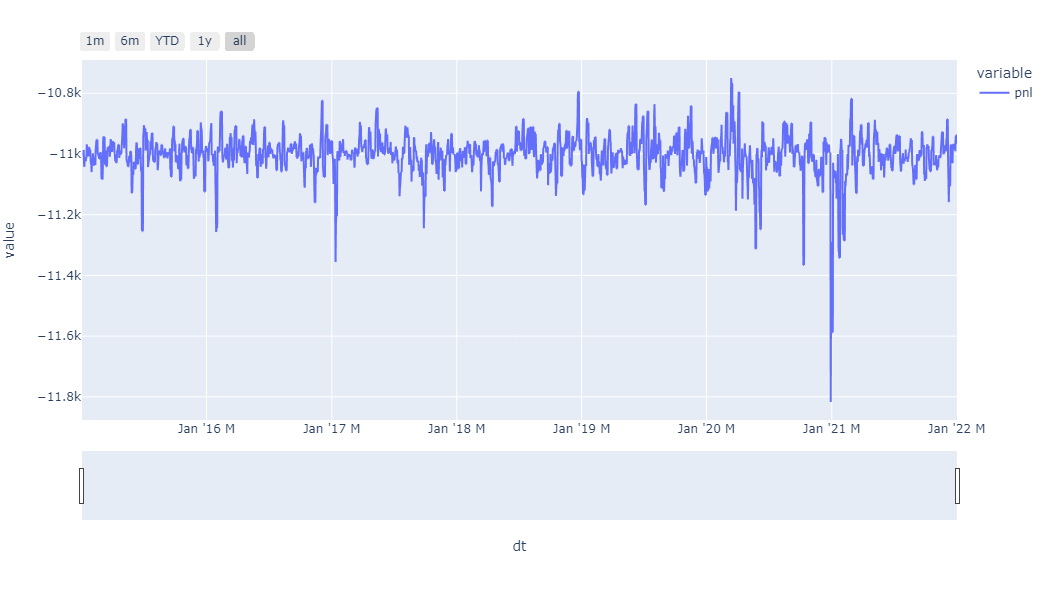

In [276]:
port_df.index.name = 'dt'
px_plot(
    port_df,
    include_cols=['pnl'],
    exclude_cols=['cash_equity', 'value'],
)

# Scratch Space

Check that the tickers noted in the prompt are present in our list:

In [37]:
for ticker in ('ASH', 'VTOL', 'ISUN', 'VIVO'):
    assert ticker in fr['ticker'].unique()

In [38]:
len(unique_index_keys(fr))

4626

In [39]:
dup_filings_mask = filings_df.groupby(level=0).apply(lambda x: x[~x.filing_date.isnull()].reset_index().duplicated(['filing_date', 'per_type']).any())

In [40]:
dup_filings = unique_index_keys(dup_filings_mask[dup_filings_mask])
dup_filings[0]

'ABLT'

In [41]:
filings_df.loc['ABLT']

,per_type,filing_date,eps_diluted_net,basic_net_eps,net_lterm_debt,tot_lterm_debt,ret_invst,tot_debt_tot_equity,profit_margin,mkt_val,shares_out
per_end_date,,,,,,,,,,,
2014-12-31,A,2014-12-31,91.4700,87.4710,-1.4780,5.9900,7.5765,0.3607,1.4466,NaN,NaN
2015-12-31,A,2015-12-31,-22.2000,-21.2060,-1.5650,4.4210,-2.0765,0.2883,-0.3700,NaN,NaN
2016-12-31,A,2016-12-31,38.9300,37.2060,-5.6510,0.1220,3.7844,0.0621,0.6865,NaN,NaN
2017-12-31,A,2017-12-31,152.5200,145.9710,0.0850,0.2490,13.3385,0.1020,2.4749,NaN,NaN
2018-09-30,Q,NaT,27.1000,NaN,0.2510,NaN,NaN,NaN,1.7837,16.5600,0.0300
2018-12-31,A,2018-12-31,254.6600,249.7100,0.2400,0.5830,18.8177,0.0263,4.0964,NaN,NaN
2019-03-31,Q,NaT,-19.5000,NaN,NaN,NaN,NaN,NaN,-1.2474,16.8800,0.0300
2019-06-30,Q,NaT,-5.4500,NaN,NaN,NaN,NaN,NaN,-0.3330,16.3900,0.0300
2019-09-30,Q,NaT,-10.9000,NaN,0.1470,0.7470,-0.8135,0.0586,-0.7244,17.2100,0.0300


In [42]:
unique_index_keys

<function __main__.unique_index_keys(df, level=0) -> List[str]>